In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from tqdm import tqdm
from PIL import Image
import io

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB2, EfficientNetB3
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [2]:
#
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 99% 147M/149M [00:01<00:00, 126MB/s]
100% 149M/149M [00:01<00:00, 137MB/s]


In [4]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# Data Prepocessing

In [5]:
path = os.getcwd()
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=256

for label in labels:
    trainPath = os.path.join(path,'Training/'+label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join(path,'Testing/'+label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 300/300 [00:00<00:00, 379.17it/s]


In [6]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2021)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


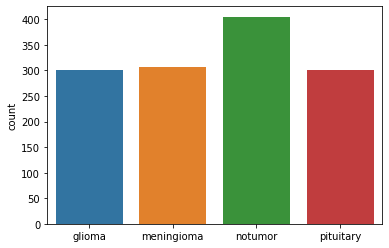

In [7]:
sns.countplot(Y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


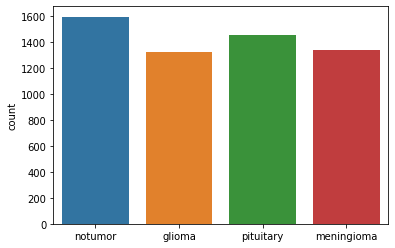

In [8]:
sns.countplot(Y_train)

In [9]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=2021)


# EfficientNetB3

In [11]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model1 = base_model.output
model1 = GlobalAveragePooling2D()(model1)
model1 = Dense(512, activation='relu')(model1)
model1 = Dropout(0.2)(model1)
model1 = Dense(4, activation='softmax')(model1)
model1 = Model(inputs = base_model.input, outputs=model1)

model1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

43950080/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [12]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

In [13]:
history1 = model1.fit(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=15, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/15
143/143 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8862
Epoch 00001: val_accuracy improved from -inf to 0.89939, saving model to brain_tumor_classification.h5
143/143 [==============================] - 249s 2s/step - loss: 0.3431 - accuracy: 0.8862 - val_loss: 0.4402 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/15
143/143 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9470
Epoch 00002: val_accuracy improved from 0.89939 to 0.92476, saving model to brain_tumor_classification.h5
143/143 [==============================] - 204s 1s/step - loss: 0.1628 - accuracy: 0.9470 - val_loss: 0.1755 - val_accuracy: 0.9248 - lr: 0.0010
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9674
Epoch 00003: val_accuracy improved from 0.92476 to 0.94488, saving model to brain_tumor_classification.h5
143/143 [==============================] - 205s 1s/step - loss: 0.1097 - accuracy: 0.9674 - val_loss: 0.173

In [14]:
test_pred = model1.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(Y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 99.08%


In [ ]:
scores = model1.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: %.2f%%\n" % (scores[1]*100))
scores = model1.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy: %.2f%%\n" % (scores[1]*100))

In [16]:
model_json = model1.to_json()
with open("efficientnetb3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("efficientnetb3.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


In [ ]:
from google.colab import files
files.download("efficientnetb3.h5")
files.download("efficientnetb3.json")

# Micro Average ROC AUC Calculation

In [18]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from cycler import cycler

n_classes = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
def multiclass_roc_auc_score(y_test, y_pred, average = "micro"):
    lb = LabelBinarizer()
    lb.fit(y_pred)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    for (i, c_label) in enumerate(n_classes):
        fpr, tpr, threshold = roc_curve(y_test[:, i], y_pred[:, i])
        c_ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)' % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average = average)

ROC AUC Score:  0.9938977879481312


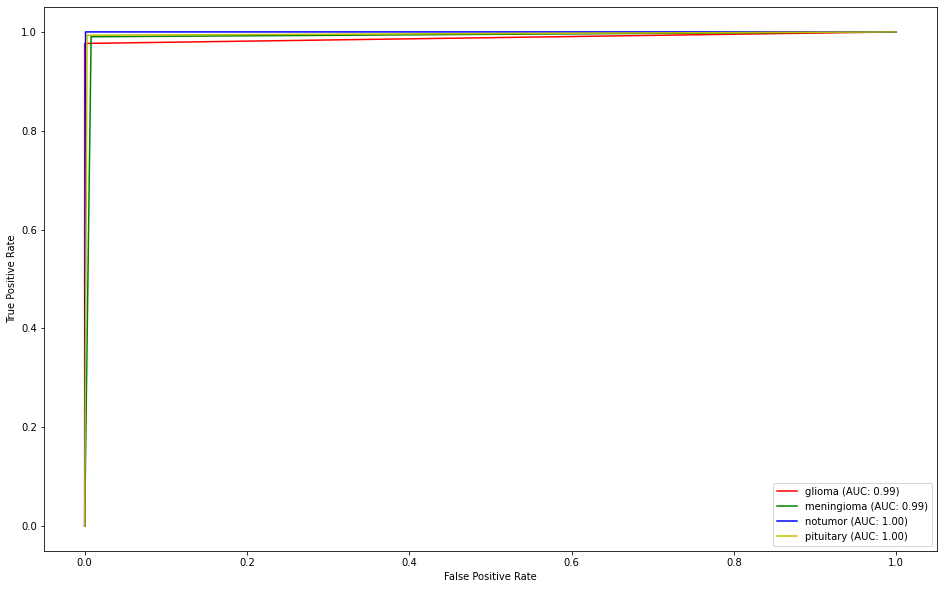

In [19]:
fig, c_ax = plt.subplots(1, 1, figsize = (16,10))
color_cycler = cycler(color=['r','g','b','y','m','k','c','#FFA500'])
c_ax.set_prop_cycle(color_cycler)

y_pred = model1.predict(X_test)
y_pred2 = y_pred.argmax(axis=-1)
Y_test2 = Y_test.argmax(axis=-1)

print('ROC AUC Score: ', multiclass_roc_auc_score(Y_test2, y_pred2))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()